# Introduction: Example for Slicer-Free Bottom-Up 3D-Printing using FullControl

The approach taken here is to design the "Infill" that a slicer would normally create first, and then
use coordinate transformations to deform it into the desired shape. The process is analogous to forging
a finished part from a blank or pre-form. <p/>
The goal is to design a capstan that fits on the shaft of a stepper motor, and which could be used in place
of a timing-gear/timing belt. Other applications could be cable-driven actuators in robotics.
The design starts with a "blank" that resembles the final shape, and then details are added in subsequent
"machining" steps:

1. Blank design: A rigid hollow cylindrical mesh.
2. "Broaching" of the center bore to fit the D-shaft of a stepper motor (5mm diameter, with a 0.5mm flat).
4. Counter-sinking the center bore.
5. Re-Shapeing the inner structure of the "blank" to make room for a wire-return-channel.
6. In a final "machining" step, cuting of a helical groove on the outside of the blank. This includes on/off
   "ramps" for the cable at the top and bottom of the capstan, and also a top and bottom chamfer.
   
   

In [1]:
from math import pi,cos
deg = pi/180
def _start(name):globals()['_start_'+name]=None
def _end(name):globals()['_end_'+name]=None
def _get(name):
    g=iter(dict(globals()).items())
    startkey,endkey='_start_'+name,'_end_'+name
    for key,value in g:
        if key==startkey:
          break
    result={}
    for key,value in g:
      if key==endkey:
          break
      elif key[0]!='_':
          result[key]=value
    return result

# Parameters

## Printer Parameters

In [2]:
# printer/gcode parameters
design_name = 'capstan'
nozzle_temp = 220
bed_temp = 120
nominal_print_speed=10*60 #print slow to give the layer time to cool
nominal_EW=0.75   # extrusion width
fan_percent = 0
EH = 0.2    # extrusion heigth
printer_name='generic' # generic / ultimaker2plus / prusa_i3 / ender_3 / cr_10 / bambulab_x1 / toolchanger_T0

In [3]:
_start('design_parameters')

## Design Parameters

In [4]:
# design parameters

l_turn= 60
# cable length per turn (mm)
# default value: 60

l_tot= 600
# total usable cable length (mm)
# default value: 600

d_cable=0.9
# cable diameter (mm)
# default value: 0.9

groove_pitch=1.25
# distance between centers of grooves (mm)
# default value: 1.25

left_handed_capstan=True
# if set to True, a mirrored version of the capstan is generated
# default value: False

n_spokes=13
# number of "Spokes" in blank
# default value: 13

n_mesh_strands=5
# number of parallel extrusions that make up the mesh
# default valuem 5

mesh_twist_pitch = -60
# pitch of mesh (spokes) (mm)
# default value: -60

n_cable_channels=2
# number of internal cable channels [1|2]
# default value: 1

hl=EH
# layer height (mmm)
# default value 0.2

ew_rim=1
# Extrusion width rim (mm)
# default value: 1

ew_spokes=0.85
# extrusion width spokes
# default value: 0.85

ew_hub=0.5
# extrusion width hub
# default value: 0.5

hub_squeezeout_factor=2.25
#correction factor for overlapping extrusions near the hub
#default value: 2.25

shaft_type='D'
# shaft type ('plain'|'D'|'DD')
# default Value: 'D'

d_shaft=5
# shaft diameter (mm)
# default value: 5

D_key=0.5
# key dimension for D-shaft (mm)
# default value: 0.5

countersink_chamfer=0.75
#width of countersink chamfer (mm)
#default value: 0.75


In [5]:
design_parameters=_get('design_parameters')

## Calculated Parameters

In [6]:
r_cable=d_cable/2
r_circ=(l_turn**2-groove_pitch**2)**0.5/(2*pi)
r_shaft=d_shaft/2
h_rim=2.0*d_cable
r_rim=r_circ+r_cable
r_cable_channel=r_circ-d_cable-ew_rim
phi_offset_channel2=0 if n_cable_channels!=2 else (n_spokes//2)/n_spokes*2*pi
dz_chamfer=1.75*d_cable#vertical tool position above/below top/bottom
r_chamfer=r_cable_channel#horizontal tool position
groove_flank_angle=30*deg
delta_phi_ramp_start=1.5*(2*pi)/n_spokes #offset relative to return channel center
delta_phi_ramp=pi/2 #
delta_phi_chamfer_transition=pi/16
dz_ends=2*(h_rim+r_cable)
phi_ends=2*(delta_phi_ramp_start+delta_phi_ramp)+phi_offset_channel2
delta_phi_helix_=(l_tot/l_turn)*2*pi#preliminary
n_rot=(dz_ends*(2*pi)+ delta_phi_helix_*groove_pitch - mesh_twist_pitch*(phi_ends + delta_phi_helix_))/(-mesh_twist_pitch*(2*pi))
n_rot=int(n_rot+1)
delta_phi_helix=(-dz_ends*(2*pi) - n_rot*mesh_twist_pitch*2*pi + phi_ends*mesh_twist_pitch)/(groove_pitch -mesh_twist_pitch)
z_bottom=0.0
z_top=z_bottom+delta_phi_helix/(2*pi)*groove_pitch+dz_ends
z_helix_start=z_bottom+h_rim+r_cable
phi_helix_start=delta_phi_ramp_start+delta_phi_ramp

# Turtle-Graphics functions
A form of Turtle Graphics is used to define the structure of the "blank". 
The cell below defines functions that turn a series of arc segments definitions into 2D points:

## Interpolate Segments

In [7]:
import numpy as np
from matplotlib import pyplot as plt
from numpy import pi,exp,sign,inf

def polygonArea(p):
  def crossprod(v1,v2):
    return v1.real*v2.imag-v2.real*v1.imag
  return 0.5*np.sum(crossprod(p[range(-1,len(p)-1)],p))

def SegmentsLength(Segs):
    return sum(l for l,*_ in Segs)

def SegmentsArea(Segs):
  nSegs=len(Segs)
  dl,dang,*opts=np.array(Segs).transpose()
  ang=np.cumsum(dang)
  ang=exp(1j*np.insert( ang,0,0))
  dang_2=np.exp(1j*dang/2)
  viSeg=np.sinc(dang/(2*pi))*dl*dang_2*ang[:-1]
  pSeg=np.cumsum(viSeg)
  olderr=np.geterr()
  np.seterr(divide='ignore',invalid='ignore')#suppress the warnings from 0/0 = nan. nansum assumes nan=0, which is the correct value in this case
  area=polygonArea(pSeg) +  np.nansum((dl/dang)**2*(dang/2.0-dang_2.real*dang_2.imag))
  np.seterr(**olderr)
  return area

def InterpSegments(Segs,t,p0=0.+0.j,a0=0+1j,scale=1.0,eps=1e-6):
  """
  Segment points are calculated for values of 't', where 't' is the normalized
  length of the path. t is in the range of [0..1[
  """
  dl,dang=np.array([(l,a) for l,a,*_ in Segs]).transpose()
  L=np.cumsum(np.insert(dl,0,0.0))
  ang_=np.cumsum(np.insert(dang,0,0.0))
  ang=exp(1j*ang_)
  viSeg=np.sinc(dang/(2*pi))*dl*scale*np.exp(1j*dang/2)*ang[:-1]
  pSeg=np.cumsum(np.insert(viSeg,0,0+0j))
  if not hasattr(t,'__getitem__'): #not an array
    t=np.array([t]) #convert to array
  else:
    if t.shape==(): #no dimensions
      t=np.array([t])
    else:
      t=np.array(t)
  T=t.astype(int)
#  t=t-T
  if ((abs(pSeg[-1])<eps) and (abs(ang[-1]-(1+0j))<eps)):
    pr,ar=np.zeros((len(t),),dtype=complex), np.ones((len(t),),dtype=complex) # closed loop. No translation/rotation necessary for t>1
  else: #endpoint of path != startpoint => repeat path for t>1 by translating and rotating it
    def rotateSecant(v,beta,T):
      beta2=beta/2
      rot2=exp(1j*beta2)
      uniqueT,inverseIndex=np.unique(T,return_inverse=True) #don't re-calculate for identical values of T
      p=(v*rot2**(uniqueT-1)/np.sinc(beta2/np.pi) * uniqueT * np.sinc(uniqueT*beta2/np.pi))[inverseIndex]
      a=(rot2**(2*uniqueT))[inverseIndex]
      return p,a
    pr,ar=rotateSecant(pSeg[-1],ang_[-1],T)
  pr+=p0
  ar*=a0
  l=L/L[-1]
  Xx=np.interp(t-T,l,range(len(l)))
  X=np.maximum(0,np.minimum(Xx.astype(int),len(dang)-1)) #segment index
  x=Xx-X#within seggment
  p=pSeg[X] + np.sinc( dang[X]*x /(2*pi))* dl[X]*x *scale*np.exp(1j* dang[X]*x /2)*ang[X]
  p=p*ar+pr
  a=ang[X]*np.exp(1j*dang[X]*x)*ar
  if len(p)==1:
      p=p[0] #convert array to single value if argument was a single value
      a=a[0]
  return p,a,L[-1]*t,X

def Segments2Complex(Segs,p0=0.+0.j,scale=1.0,a0=0+1j,tol=0.05,offs=0,loops=1,return_start=False):
  """
  The parameter "tol defines the resolution. It is the maximum allowable
  difference between circular arc segment, and the secant between the
  calculated points on the arc. Smaller values for tol will result in
  more points per segment.
  """
  a=a0
  p=p0
  p-=1j*a*offs
  L=0
  if return_start:
      yield p,a,L,-1 #assuming closed loop: start-point = end-point
  loopcount=0
  while (loops==None) or (loops==inf) or (loopcount<loops):
      loopcount+=1
      for X,(l,da,*_) in enumerate(Segs):
        l=l*scale
        if da!=0:
          r=l/da
          r+=offs
          if r!=0:
            l=r*da
            dl=2*abs(2*r*tol)**0.5
            n=max(int(abs(6*(da/(2*pi)))),int(l//dl)+1)
          else:
            n=1
          dda=exp(1j*da/n)
          dda2=dda**0.5
          v=(2*r*dda2.imag)*dda2*a
        else:
          n=1
          dda=1
          v=l*a
        for i in range(n):
          L+=l/n
          p+=v
          yield p,a,L,X
          v*=dda
          a*=dda

# Step-by-Step Design

## Blank design
The blank is designed analogous to a bycicle wheel, with a rim on the outside, a hub in the center, and interweaving "spokes" connecting the two. 

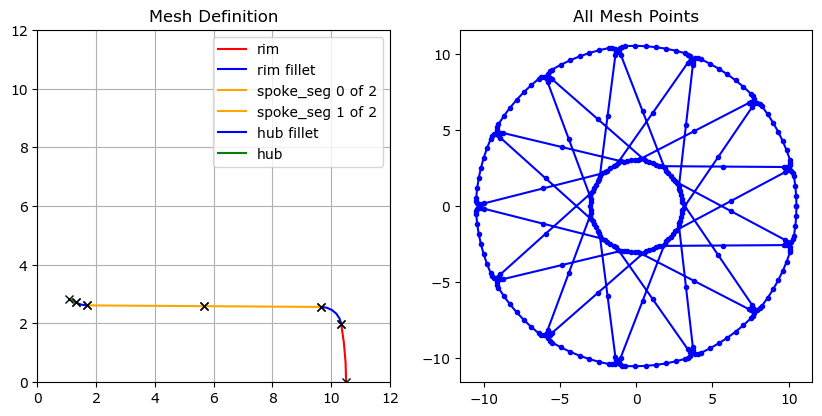

In [8]:
def mirror(a): return a+a[::-1]
def meshSegment(l=1,nl=1,w1=0.5,w2=0.5,r1=0.1,r2=0.1,a=60*deg,c=0*deg,da=0,daw=0):
    return [(w1/2,daw/2,dict(EW=ew_rim,c='r',descr='rim')),
            (r1*a,a+da/4-daw/2-c/4,dict(EW=ew_spokes,c='b',descr='rim fillet')),
            *((l/nl,c/2,dict(EW=ew_spokes*(1-i/(nl-1))+ew_hub*(i/(nl-1)),c='orange',descr=f'spoke_seg {i} of {nl}')) for i in range(nl)),
            (r2*a,-a+da/4-daw/2-c/4,dict(EW=ew_hub,c='b',descr='hub fillet')),
            (w2/2,daw/2,dict(EW=ew_hub,c='g',descr='hub'))]

blank_MeshDefinition=meshSegment(l=8,nl=2,w1=4,w2=0.5,r1=1,r2=0.4,a=55*deg,da=2*pi/(n_spokes/n_mesh_strands),c=0*deg,daw=0.7* 2*pi/n_spokes)
blank_Segments=mirror(blank_MeshDefinition)

blank_points,_,L_blank,*_,blan_segidx=list(zip(*Segments2Complex(blank_Segments,scale=1,tol=0.01,loops=n_spokes,return_start=True)))
blank_points=np.array(blank_points)

#center the blank
blank_points=np.array(blank_points)
blank_ro=max(blank_points.imag)
blank_points+=blank_ro

#Plot results of step 1:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
p0=blank_ro
a0=1j
for segment in blank_MeshDefinition:
    points=np.array(list(p for p,*_ in Segments2Complex([segment],p0=p0,a0=a0,scale=1,tol=0.01,return_start=True)))
    props=segment[-1]
    ax1.plot(points.real,points.imag,c=props['c'],label=props['descr'])
    ax1.plot(points[[0,-1]].real,points[[0,-1]].imag,'kx')
    p0=points[-1]
    a0*=np.exp(1j*segment[1])
ax1.set_title('Mesh Definition')
ax1.set_xlim(0,12)
ax1.set_ylim(0,12)
ax1.set_aspect('equal')
ax1.grid()
ax1.legend(loc='upper right')
ax2.set_title('All Mesh Points')
ax2.plot(blank_points.real,blank_points.imag,'b.-')
ax2.set_aspect('equal')

## "Broaching" of the D-key


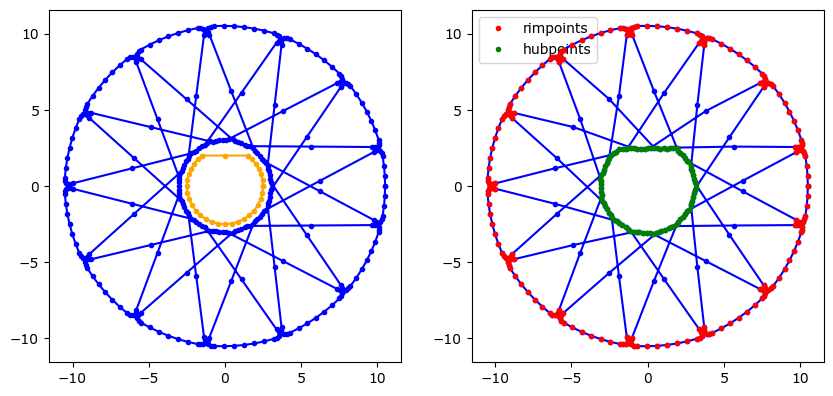

In [9]:

#in cylinder-coordinates:
blank_amp=abs(blank_points)
blank_phase=blank_points/blank_amp
blank_ri=min(blank_amp)

#calculate the geometry of the D-key "broaching tool"
if shaft_type.upper()=='PLAIN':
    DshaftOutline=[(r_shaft*2*pi,2*pi)]#'plain' shaft outline is a circle
else:
    Dkeycp = (r_shaft**2-(r_shaft-D_key)**2)**0.5 + 1j*(r_shaft-D_key)#corner point of D-shaft (x+ iy)
    Dkeyang=np.log(Dkeycp).imag # angle up to the corner point
    DshaftOutline=[(r_shaft*Dkeyang,Dkeyang),(0,pi/2-Dkeyang),(Dkeycp.real,0)]#1/4 of D-shaft outline
    DshaftOutline=DshaftOutline+DshaftOutline[-1::-1]#add mirror image -> upper half of D-shaft outlone
    DshaftOutline+=DshaftOutline if shaft_type.upper()=='DD' else [(r_shaft*pi,pi)] #add lower half of D-shaft outline
    

hub_limit=(0.2*blank_ro+0.8*blank_ri) #inner 20%
rim_limit=(0.8*blank_ro+0.2*blank_ri) #outer 20%
isRimpoint=blank_amp>rim_limit
isHubpoint=blank_amp<hub_limit
isSpokespoint=~isHubpoint&~isRimpoint

DshaftPoints=blank_points.copy() #copy points from previous step

#modify only the points near the hub:
DshaftPoints[isHubpoint]=InterpSegments(DshaftOutline,(np.log(DshaftPoints[isHubpoint]).imag)/(2*pi)%1,p0=r_shaft)[0] \
                          *(blank_amp[isHubpoint]/blank_ri*r_shaft+hub_squeezeout_factor*ew_hub/2)/r_shaft

#plot the results after step 2:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(blank_points.real,blank_points.imag,'b.-')
ax1.plot(*list(zip(*[(p.real,p.imag) for p,*_ in Segments2Complex(DshaftOutline,p0=r_shaft,return_start=True,tol=0.01)])),'.-',c='orange',zorder=6)
ax2.plot(DshaftPoints.real,DshaftPoints.imag,'b.-',zorder=6)
ax2.plot(DshaftPoints[isRimpoint].real,DshaftPoints[isRimpoint].imag,'r.',zorder=7,label='rimpoints')
ax2.plot(DshaftPoints[isHubpoint].real,DshaftPoints[isHubpoint].imag,'g.',zorder=8,label='hubpoints')

for ax in(ax1,ax2):
  ax.set_aspect('equal')
ax2.legend(loc='upper left');

## Countersink

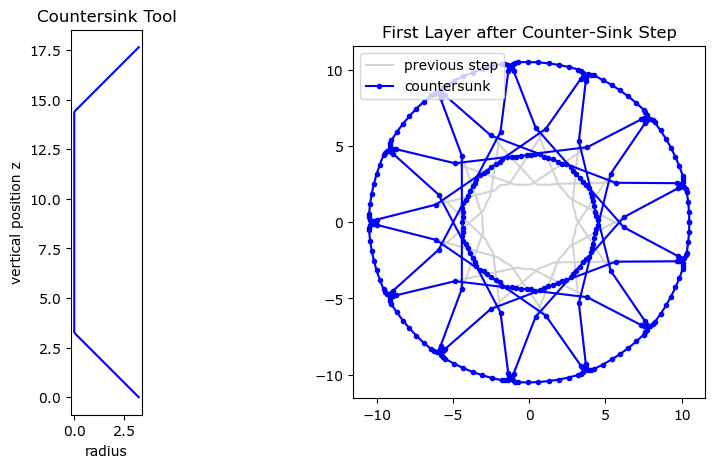

In [10]:

zr=np.linspace(z_bottom,z_top,200)

def rCountersink(z):
    return np.maximum(np.maximum(0,countersink_chamfer+r_shaft-(z-z_bottom)),countersink_chamfer+r_shaft-(z_top-z))

z=z_bottom
countersunkPoints=DshaftPoints.copy() #copy points from previous step

CountersinkApplies=((rCountersink(z)+hub_squeezeout_factor*ew_hub)>abs(DshaftPoints))&isHubpoint #determine affected points

#modify only the affected points:
countersunkPoints[CountersinkApplies]=blank_points[CountersinkApplies]/blank_ri*(rCountersink(z)+hub_squeezeout_factor*ew_hub)

#Plot the results after step 3:
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(10,5))
ax1.plot(rCountersink(zr),zr,'b')
ax1.set_xlabel('radius')
ax1.set_ylabel('vertical position z')
ax1.set_title('Countersink Tool')
ax2.plot(DshaftPoints.real,DshaftPoints.imag,c='lightgray',label='previous step')
ax2.plot(countersunkPoints.real,countersunkPoints.imag,'b.-',label='countersunk')

for ax in(ax1,ax2):
  ax.set_aspect('equal')
ax2.set_title('First Layer after Counter-Sink Step')
ax2.legend(loc='upper left');

## Shaping the wire-return-channel

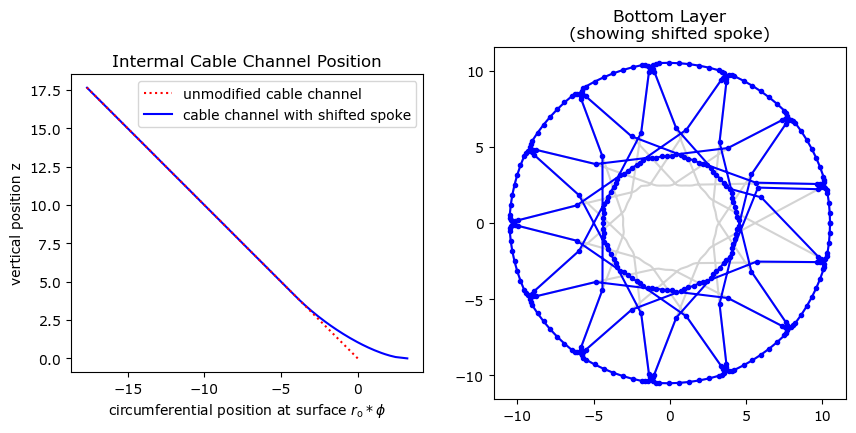

In [11]:

r_lead_in=4.0
phi_center,phi_width,max_phase_advance=0.5*2*pi/n_spokes,2*pi/n_spokes,  0.7*2*pi/n_spokes
max_advance_bottom=[(1.0-(r_lead_in**2-min(max(r_lead_in-(z-z_bottom),0.0),r_lead_in)**2)**0.5/r_lead_in) for z in zr]

def phase_advance(phi,phi_center,phi_width,max_phase_advance):
    dphi=np.minimum(1,abs((phi-phi_center+pi)%(2*pi)-pi)/phi_width)*pi
    return np.exp(1j*max_phase_advance*(0.5+0.5*np.cos(dphi)))

phaseshiftedPoints=countersunkPoints.copy() #cpoy results from previous step

#do not phase_shift points near the hub:
phaseshiftedPoints[isSpokespoint]=phase_advance(np.log(countersunkPoints[isSpokespoint]).imag,0*phi_center,phi_width,max_phase_advance)*countersunkPoints[isSpokespoint]

#plot the results after step 4:
fig,(ax3,ax4)=plt.subplots(1,2,figsize=(10,5))
ax3.plot(-zr,zr,'r:',label='unmodified cable channel',zorder=4)
ax3.plot([x*max_phase_advance/(2*pi)*l_turn-z for x,z in zip(max_advance_bottom,zr)],zr,'b-',label='cable channel with shifted spoke',zorder=2)
ax3.set_aspect('equal')
ax3.set_ylabel('vertical position z')
ax3.set_xlabel('circumferential position at surface $r_\mathrm{o}*\phi$')
ax3.set_title('Intermal Cable Channel Position')
ax3.legend( loc='upper right')
ax4.plot(phaseshiftedPoints.real,phaseshiftedPoints.imag,'b.-',zorder=6)
ax4.plot(DshaftPoints.real,DshaftPoints.imag,c='lightgray',label='previous step')
ax4.set_title('Bottom Layer\n(showing shifted spoke)')
ax4.set_aspect('equal')

## Cutting the groove

In [12]:
from math import cos,pi
def alpha_blend(x,xstart, xend,f0,f1):
    alpha=0.5+0.5*cos(max(0.0,min(1,(x-xstart)/(xend-xstart)))*pi)
    return [alpha*y0+(1.0-alpha)*y1 for y0,y1 in zip(f0(x),f1(x))]

phi_0=delta_phi_ramp_start-delta_phi_chamfer_transition-phi_center
phi_1=phi_0+delta_phi_chamfer_transition
phi_2=phi_1+delta_phi_ramp
phi_3=phi_2+delta_phi_helix
phi_4=phi_3+delta_phi_ramp
phi_5=phi_4+delta_phi_chamfer_transition

#tool paths:
#variable input parameters
def groove_toolpath(phi):
    def bottom_chamfer(phi):  return [ r_chamfer,         z_bottom-dz_chamfer ]
    def bottom_cable(phi):    return [ r_cable_channel,  z_bottom-r_cable ]
    def helix(phi):           return [ r_circ,            (phi-phi_2)/(2*pi)*groove_pitch+h_rim+r_cable ]
    def top_cable(phi):       return [ r_cable_channel,  z_top+r_cable ]
    def top_chamfer(phi):     return [ r_chamfer,         z_top+dz_chamfer ]

    if    phi<phi_0              : return  bottom_chamfer(phi)
    elif (phi>=phi_0)&(phi<phi_1): return  alpha_blend(phi,phi_0,phi_1,bottom_chamfer,bottom_cable)
    elif (phi>=phi_1)&(phi<phi_2): return  alpha_blend(phi,phi_1,phi_2,bottom_cable,helix)
    elif (phi>=phi_2)&(phi<phi_3): return  helix(phi)
    elif (phi>=phi_3)&(phi<phi_4): return  alpha_blend(phi,phi_3,phi_4,helix,top_cable)
    elif (phi>=phi_4)&(phi<phi_5): return  alpha_blend(phi,phi_4,phi_5,top_cable,top_chamfer)
    elif  phi>=phi_5             : return  top_chamfer(phi)
    else: raise(Exception('This line should never be reached.'))


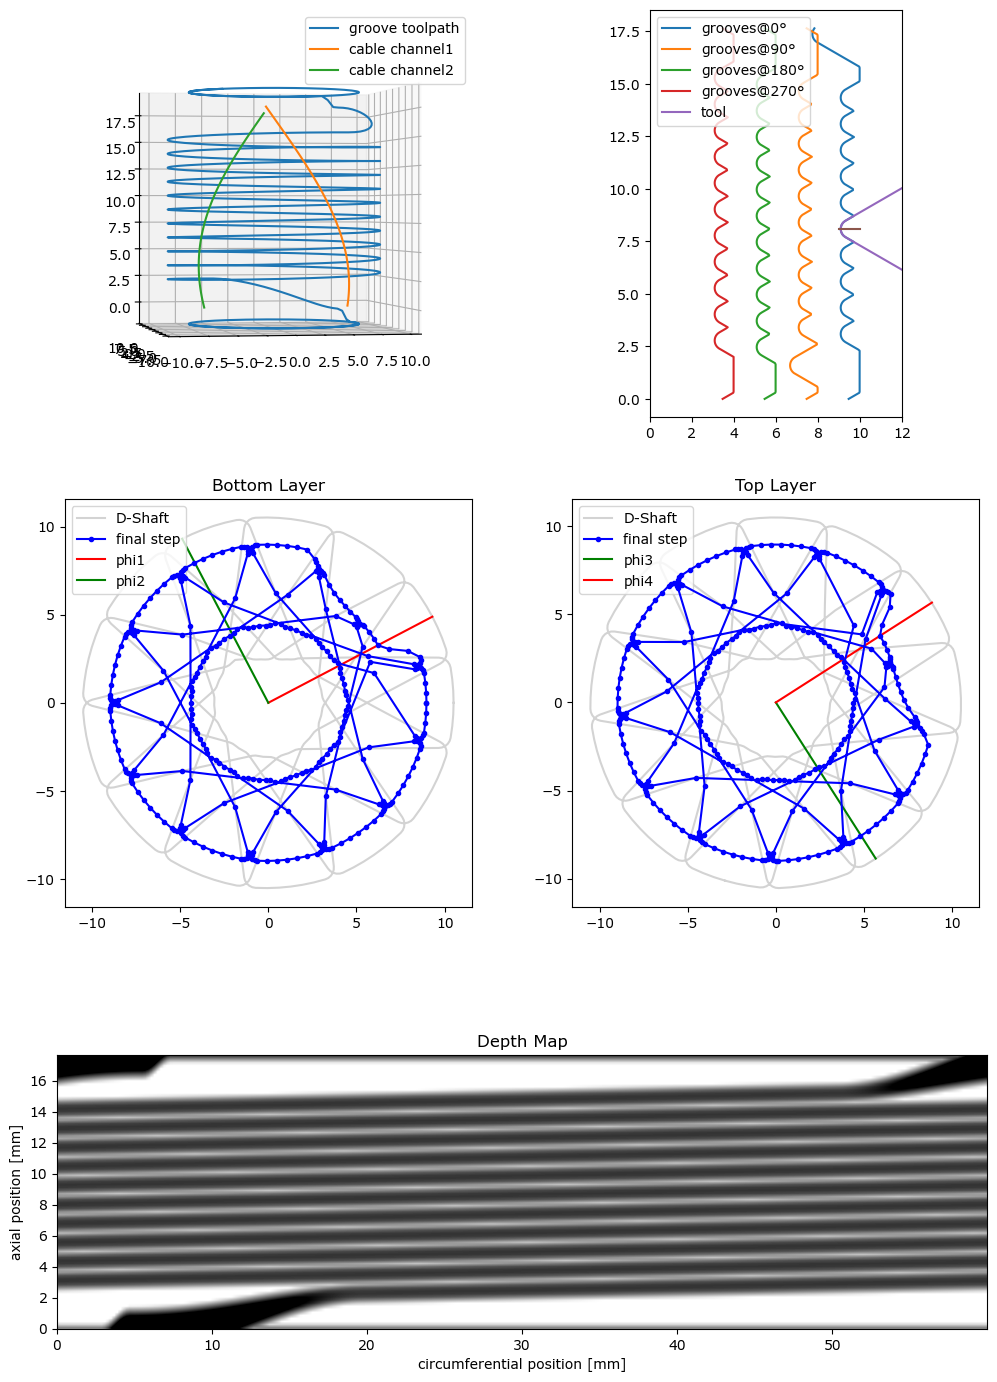

In [13]:
def groove_tool(dz,r=0.45,a=30*deg):
    flank=abs(dz)>r*np.cos(a)
    if flank:
      result=abs(dz)/np.tan(a)-r/np.sin(a)
    else:
      result=-(r**2 - dz**2)**0.5
    return result

def phi_groove(z):
    return (z-z_helix_start)/groove_pitch*(2*pi)+phi_helix_start

def thread_depth_pattern(z,phi,z0=0.0):
    i_groove=(phi_groove(z)-pi)//(2*pi)
    phi_tool_1=(phi)%(2*pi)+i_groove*(2*pi)
    r_tool_1,z_tool_1=groove_toolpath(phi_tool_1)
    dz_1=z_tool_1-z
    if abs(dz_1)<=(groove_pitch/2):
        return r_tool_1+groove_tool(dz=dz_1,r=r_cable,a=groove_flank_angle)
    phi_tool_2=phi_tool_1+2*pi
    r_tool_2,z_tool_2=groove_toolpath(phi_tool_2)
    dz_2=z_tool_2-z
    if abs(dz_2)<=(groove_pitch/2):
        return r_tool_2+groove_tool(dz=dz_2,r=r_cable,a=groove_flank_angle)
    while dz_1>0:
        phi_tool_2,r_tool_2,z_tool_2,dz_2=phi_tool_1,r_tool_1,z_tool_1,dz_1
        phi_tool_1=phi_tool_1-2*pi
        r_tool_1,z_tool_1=groove_toolpath(phi_tool_1)
        dz_1=z_tool_1-z
    while dz_2<0:
        phi_tool_1,r_tool_1,z_tool_1,dz_1=phi_tool_2,r_tool_2,z_tool_2,dz_2
        phi_tool_2=phi_tool_2+2*pi
        r_tool_2,z_tool_2=groove_toolpath(phi_tool_2)
        dz_2=z_tool_2-z
    r_2=r_tool_2+groove_tool(dz=dz_2,r=r_cable,a=groove_flank_angle)
    r_1=r_tool_1+groove_tool(dz=dz_1,r=r_cable,a=groove_flank_angle)
    return min(r_1,r_2,r_rim)
#    return dz_1
#    dz=abs((z-z0-phi/(2*pi)*groove_pitch+groove_pitch/2)%groove_pitch-groove_pitch/2)


TopMeshAng=(z_top-z_bottom)/mesh_twist_pitch*(2*pi)
TopMeshRot=np.exp(1j*TopMeshAng)
BlankPointsTop=blank_points*TopMeshRot #rotate the mesh
DshaftPointsTop=BlankPointsTop.copy()
#modify only the points near the hub:
DshaftPointsTop[isHubpoint]=InterpSegments(DshaftOutline,(np.log(DshaftPointsTop[isHubpoint]).imag)/(2*pi)%1,p0=r_shaft)[0] \
                          *(abs(BlankPointsTop[isHubpoint])/blank_ri*r_shaft+hub_squeezeout_factor*ew_hub/2)/r_shaft
#DshaftPointsTop[isHubpoint]=2.5*DshaftPointsTop[isHubpoint]/abs(DshaftPointsTop[isHubpoint])*(abs(BlankPointsTop[isHubpoint])/blank_ri*r_shaft+hub_squeezeout_factor*ew_hub/2)/r_shaft
countersunkPointsTop=countersunkPoints*TopMeshRot
phaseshiftedPointsTop=countersunkPointsTop.copy()

phaseshiftedPointsTop[isSpokespoint]=phase_advance(np.log(countersunkPointsTop[isSpokespoint]).imag,TopMeshAng-2*phi_center-phi_offset_channel2,phi_width,-max_phase_advance)*countersunkPointsTop[isSpokespoint]

finalPointsBottom=phaseshiftedPoints.copy()
finalPointsBottomAmp=abs(finalPointsBottom)
finalPointsBottomPhase=finalPointsBottom/finalPointsBottomAmp
finalPointsBottom[isRimpoint]=(np.vectorize(thread_depth_pattern)(z_bottom,np.log(finalPointsBottomPhase[isRimpoint]).imag)-ew_rim/2)*(finalPointsBottom[isRimpoint]/blank_ro)

finalPointsTop=phaseshiftedPointsTop.copy()
finalPointsTopAmp=abs(finalPointsTop)
finalPointsTopPhase=finalPointsTop/finalPointsTopAmp
finalPointsTop[isRimpoint]=(np.vectorize(thread_depth_pattern)(z_top,np.log(finalPointsTopPhase[isRimpoint]).imag)-ew_rim/2)*(finalPointsTop[isRimpoint]/blank_ro)

#plot the results
fig=plt.figure(figsize=(12,18))
ax1=fig.add_subplot(3,2,2)
ax2=fig.add_subplot(3,2,1,projection='3d')
ax3=fig.add_subplot(3,2,3)
ax4=fig.add_subplot(3,2,4)
ax5=fig.add_subplot(3,1,3)
zmid=(z_top+z_bottom)/2
phi=np.linspace(-3*pi,phi_5+3*pi,1000)
r,z=np.array([groove_toolpath(phi_) for phi_ in phi]).T
p=r*np.exp(1j*phi)
ax2.plot3D(p.real,p.imag,z,label='groove toolpath')
z=np.linspace(z_bottom,z_top,100)
phi=z/mesh_twist_pitch*2*pi
for i,phi_offs in enumerate((0,-phi_offset_channel2)):
  p=(blank_ri+blank_ro)/2*exp(1j*(phi_offs+phi))
  ax2.plot3D(p.real,p.imag,z,label=f'cable channel{i+1}')
limits = np.array([getattr(ax2, f'get_{axis}lim')() for axis in 'xyz'])
ax2.set_box_aspect(np.ptp(limits, axis = 1))
ax2.view_init(elev=0, azim=-100 , roll=0)
ax2.legend(loc='upper right');#,bbox_to_anchor=((1.05,0,1,1)))
z=np.linspace(z_bottom,z_top,301 )
for i in range(4):
  phi_=i/4*(2*pi)
  ax1.plot([thread_depth_pattern(zi,phi_)-2*i for zi in z],z,label=f'grooves@{phi_/deg:.0f}°')
z_tool=groove_toolpath(5*(2*pi))[1]
ax1.plot([r_circ+groove_tool(z_-z_tool) for z_ in z],z,label='tool')
ax1.plot((9,10),(z_tool,z_tool))
ax1.set_xlim(0,12)
ax1.legend()
ax1.set_aspect('equal')
ax3.plot(DshaftPoints.real,DshaftPoints.imag,c='lightgray',label='D-Shaft')
ax3.plot(finalPointsBottom.real,finalPointsBottom.imag,'b.-',zorder=6,label='final step')
phi1point=blank_ro*exp(1j*phi_1)
ax3.plot([0,phi1point.real],[0,phi1point.imag] ,'r-',label='phi1')
phi2point=blank_ro*exp(1j*phi_2)
ax3.plot([0,phi2point.real],[0,phi2point.imag] ,'g-',label='phi2')
ax3.legend(loc='upper left')
ax3.set_title('Bottom Layer')
ax3.set_aspect('equal')
ax4.plot(DshaftPointsTop.real,DshaftPointsTop.imag,c='lightgray',label='D-Shaft')
ax4.plot(finalPointsTop.real,finalPointsTop.imag,'b.-',zorder=6,label='final step')
phi3point=blank_ro*exp(1j*phi_3)
ax4.plot([0,phi3point.real],[0,phi3point.imag] ,'g-',label='phi3')
phi4point=blank_ro*exp(1j*phi_4)
ax4.plot([0,phi4point.real],[0,phi4point.imag] ,'r-',label='phi4')
ax4.set_title('Top Layer')
ax4.legend(loc='upper left')
ax4.set_aspect('equal')
z=np.arange(z_bottom,z_top+hl,hl)
phi=np.linspace(0.0,2*pi,300)
Phi,Z=np.meshgrid(phi,z)
R=np.vectorize(thread_depth_pattern)(Z,Phi)
ax5.imshow(R, interpolation='bilinear', cmap='gray',
               origin='lower', extent=[0,r_circ*2*pi, z_bottom, z_top],
               vmax=r_circ+r_cable, vmin=r_circ-1.5*r_cable)
ax5.set_title('Depth Map')
ax5.set_ylabel('axial position [mm]')
ax5.set_xlabel('circumferential position [mm]')
ax5.set_aspect('equal')

# Full Control

In [14]:
 if 'google.colab' in str(get_ipython()):
  try:
    import fullcontrol as fc
  except Exception as e:
    print(e)
    print('Attempting to install missing packages. Please wait ...')
    !pip install git+https://github.com/FullControlXYZ/fullcontrol --quiet
    import fullcontrol as fc
  from google.colab import files
import fullcontrol as fc
from math import cos, tau

## Python Program

In [20]:
from cmath import inf,polar
def phase(p):return p/abs(p)
def amplitude(p):return abs(p)
def angle(p):return polar(p)[1]
steps=[]

print_speed=nominal_print_speed
FilamentDiameter=1.75
tol=0.01
ehmin=hl/4

#priming spiral
nspiral=2.9 #spiral ends short of start to prevent dragging of loose filament into the print
spiraloffs=1.5
n=200
dang=2*pi/n
dr=(nominal_EW-0.1)/n #tight spiral
startang=-2*pi*nspiral#start backwards so that the end is close to startpoint of print
ang=startang
r=blank_ro+spiraloffs
p=r*exp(1j*ang)
steps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=hl)))
steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=EH,width=nominal_EW))
steps.append(fc.Extruder(on=True))
while ang<0:
  p=r*exp(1j*ang)
  steps.append(fc.Point(x=p.real,y=p.imag))
  ang+=dang
  r+=dr
steps.append(fc.Extruder(on=False))

L_layer=SegmentsLength(blank_Segments)*n_spokes#extrusion length per layer
dzdL=hl/L_layer


z0=z_bottom+ehmin
initialized=False
def CapstanPointGenerator():
    #Step 1: creating the blank (loop forever through the points defined by blank_Segments)
    for p_blank,_,L,*_,X in Segments2Complex(blank_Segments,p0=blank_ro,a0=1j,scale=1,return_start=True,tol=0.01,loops=inf):
      z=dzdL*L+z0 #the z-position is proportional the total extrusion path length of the blank mesh
      if z>(z_top+hl): #stop when the top is reached
        return
      eh=min(z-z_bottom if z<(z_bottom+hl+ehmin) else hl ,z_top-(z-hl))
      ew=blank_Segments[X][-1]['EW']#extract the extrusion width information from the segments specs
      mesh_angle=z/mesh_twist_pitch*(2*pi)
      p_twisted_mesh=p_blank*np.exp(1j*mesh_angle) #twist the
      p_countersunk_Dshaft=p_twisted_mesh
      #Step 2 and 3: D_shaft or countersink
      if amplitude(p_twisted_mesh)<hub_limit: #replace point if affected by D_shaft or countersink
          p_Dshaft=InterpSegments(DshaftOutline,angle(p_twisted_mesh)/(2*pi)%1,p0=r_shaft)[0] \
                              *(amplitude(p_twisted_mesh)/blank_ri*r_shaft+hub_squeezeout_factor*ew/2)/r_shaft
          p_countersunk=p_twisted_mesh/blank_ri*(rCountersink(z)+hub_squeezeout_factor*ew/2)  # Step 3: Counter-sinking of center bore
          p_countersunk_Dshaft=p_countersunk if amplitude(p_countersunk)>amplitude(p_Dshaft) else p_Dshaft #furthest from center line
      #Step 4: Shifting of spokes for internal cable channels
      p_phaseshifted=p_countersunk_Dshaft
      if (amplitude(p_phaseshifted)>hub_limit) and (amplitude(p_phaseshifted)<rim_limit):#spokes mid-points only are affected by phase shift for internal cable channel
        #bottom lead-in:
        phase_advance_z=(1.0-(r_lead_in**2-min(max(r_lead_in-(z-z_bottom),0.0),r_lead_in)**2)**0.5/r_lead_in)*max_phase_advance
        p_phaseshifted*=phase_advance(angle(p_phaseshifted),
                           phi_center=0*phi_center+mesh_angle, phi_width=phi_width,
                           max_phase_advance=phase_advance_z)
        #top lead-out:
        phase_advance_z=-(1.0-(r_lead_in**2-min(max(r_lead_in-(z_top-z),0.0),r_lead_in)**2)**0.5/r_lead_in)*max_phase_advance
        p_phaseshifted*=phase_advance(angle(p_phaseshifted),
                           phi_center=-2*phi_center+mesh_angle-phi_offset_channel2, phi_width=phi_width,
                           max_phase_advance=phase_advance_z)
      #Step 5: Cutting of cable groove and chamfering of top and bottom edge
      p_grooved=p_phaseshifted
      if amplitude(p_phaseshifted)>rim_limit:#
        p_grooved=(thread_depth_pattern(z,angle(p_grooved))-ew/2)*(p_grooved/blank_ro)
    
      p_finished=p_grooved
      yield p_finished,min(z,z_top),eh,ew
        
old_eh=-1
old_ew=-1        
for p_finished,z,eh,ew in CapstanPointGenerator():
  #update extrusion geometry if it has changed
  if (abs(eh-old_eh)/hl)>0.01 or abs(ew-old_ew)>0.005:
   # print(f'{zb=}{z=}{zt=}{eh=}{w=}')
    steps.append(fc.ExtrusionGeometry(area_model='rectangle',height=eh,width=ew))
    steps.append(fc.Printer(print_speed=nominal_print_speed*nominal_EW/ew))#set print speed to keep extrusion rate constant
    old_eh=eh
    old_ew=ew
  if left_handed_capstan==True:
    p_finished=p_finished.conjugate()
  if not initialized:
    steps.extend(fc.travel_to(fc.Point(x=p_finished.real,y=p_finished.imag)))
    steps.extend(fc.travel_to(fc.Point(z=z)))
    steps.append(fc.Extruder(on=True))
    initialized=True
  else:
    steps.append(fc.Point(x=p_finished.real,y=p_finished.imag,z=z))
steps.append(fc.Extruder(on=False))
steps.extend(fc.travel_to(fc.Point(x=0,y=0)))
#steps.extend(fc.travel_to(fc.Point(z=max(z_top+10,30))))
# offset the whole procedure. z dictates the gap between the nozzle and the bed for the first layer, assuming the model was designed with a first layer z-position of 0
model_offset = fc.Vector(x=100, y=100, z=0.0*hl)
#print(f'{w=} {eh=}')
steps = fc.move(steps, model_offset)

wiresteps=[]
for phi in np.linspace(-3*pi,phi_5+3*pi,1000):
    r,z=groove_toolpath(phi)
    p=r*np.exp(1j*phi)
    if left_handed_capstan==True:
        p=p.conjugate()
    wiresteps.extend(fc.travel_to(fc.Point(x=p.real,y=p.imag,z=z)))
wiresteps = fc.move(wiresteps, model_offset)


## FullControl Preview

<Figure size 640x480 with 0 Axes>

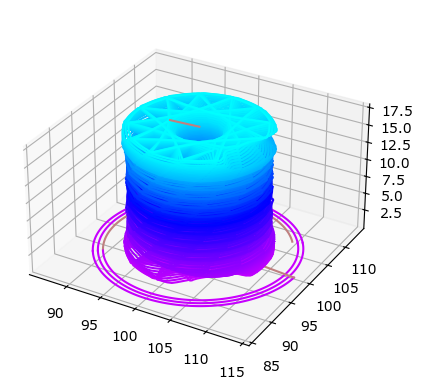

In [23]:
# add annotations and plot
import os
style='tube'
fc.transform((wiresteps if not ('iPad' in os.uname().machine) else [])+steps, 'plot', fc.PlotControls(style=style if not ('iPad' in os.uname().machine) else 'line',color_type='print_sequence'));

## FullControl G-Code

In [24]:
#design parameters
specs=''';
;Designed by:
;  FullControl_Capstan.ipynb'''
#specs+='\n;Printer Parameters:\n;  '+'\n;  '.join(f'{key}={value}' for key,value in printer_parameters.items())
specs+='\n;Design Parameters:\n;  '+'\n;  '.join(f'{key}={value}' for key,value in design_parameters.items())
#printer_name = 'Prusa_Mendel'
gcode_controls = fc.GcodeControls(
    printer_name=printer_name,
    save_as=design_name,
    initialization_data={
        'primer': 'no_primer',
        'print_speed': print_speed,
        'nozzle_temp': nozzle_temp,
        'bed_temp': bed_temp,
        'fan_speed':fan_percent,
        'design_parameters':specs,
         })
gcode = fc.transform(steps, 'gcode', gcode_controls)

In [18]:
from sympy import solve,symbols
z_tot,phi_tot,n_rot,phi_helix,phi_mesh,phi_ends,dz_ends,pitch_helix,pitch_mesh,tau=symbols('z_tot,phi_tot,n_rot,phi_helix,phi_mesh,phi_ends,dz_ends,pitch_helix,pitch_mesh,tau')
solve([
    phi_mesh/tau*pitch_mesh+z_tot,
    phi_helix/tau*pitch_helix+dz_ends-z_tot,
    phi_ends+phi_mesh+phi_helix-tau*n_rot,],
      [z_tot,phi_helix,phi_mesh])

{phi_helix: (-dz_ends*tau - n_rot*pitch_mesh*tau + phi_ends*pitch_mesh)/(pitch_helix - pitch_mesh),
 phi_mesh: (dz_ends*tau + n_rot*pitch_helix*tau - phi_ends*pitch_helix)/(pitch_helix - pitch_mesh),
 z_tot: (-dz_ends*pitch_mesh*tau - n_rot*pitch_helix*pitch_mesh*tau + phi_ends*pitch_helix*pitch_mesh)/(pitch_helix*tau - pitch_mesh*tau)}

In [19]:
solve(phi_helix-(-dz_ends*tau - n_rot*pitch_mesh*tau + phi_ends*pitch_mesh)/(pitch_helix - pitch_mesh),n_rot)

[(-dz_ends*tau - phi_helix*pitch_helix + pitch_mesh*(phi_ends + phi_helix))/(pitch_mesh*tau)]